### Setup Libs

In [1]:
!pip install tensorflow-io

     |████████████████████████████████| 23.1 MB 1.4 MB/s 


### Importing the Libs

In [2]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.python.client import device_lib

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

### Extracting the files from the zip to the folder

In [3]:
filePath = '/content/drive/MyDrive/Test_Dataset/gc-dataset.zip'

In [4]:
!mkdir gcImages

In [5]:
!unzip /content/drive/MyDrive/Test_Dataset/gc-dataset.zip -d /content/gcImages

Streaming output truncated to the last 5000 lines.
  inflating: /content/gcImages/content/gc-dataset/train/5067.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/6851.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/3295.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/5518.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/7501.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/836.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/7283.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/2323.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/3291.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/5818.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/3408.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/6164.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/7634.jpg  
  inflating: /content/gcImages/content/gc-dataset/train/2078.jpg  
  inflating:

### Global Var

In [6]:
dataset_path = '/content/gcImages/content/gc-dataset'
imgDirPath = '/content/gcImages/content/gc-dataset/train'
osSep = '/'
dataPath = imgDirPath + osSep + '*.jpg'

In [55]:
# function to plot the rgb images in given range
def plotRGBImages(rgb_ds, img_count):
    # plt.figure(figsize=(100,60))
    imgs = []

    for rgb_img in rgb_ds.take(img_count):
        imgs.append(rgb_img[0])

    imgs = np.array(imgs)

    print(imgs.shape)

    total_img = img_count

    if total_img == 1:
        plt.imshow(imgs[0])
    else:
    
        # if there are odd no of imgs
        if total_img & 1 == 1 and total_img != 1:
            total_img -= 1
            print("Only Showing", total_img)
    
        row = total_img // 3 + total_img % 3
        col = total_img // row
        # print(row, col)
        f, axs = plt.subplots(row, col)
        # print(len(axs))
        i = 0;

        if total_img == 2:        
            for ax in axs:
                ax.imshow(imgs[i])
                i += 1
        else:
            for r in range(row):
                for c in range(col):
                    axs[r,c].imshow(imgs[i])
                    i += 1

    plt.tight_layout()
    plt.show()

In [8]:
# to get the single channel out of img
def getLABSingleChannel(img, channel):
    z = np.zeros(img.shape)
    if channel != 0:
        # set sum lightness
        z[:,:,0] = 100 
    z[:,:,channel] = img[:,:,channel]
    z = lab2rgb(z)
    return(z)


In [9]:
# function to plot the lab channel in gray map
def plotLABSingleChannelGrayMap (ax, image, channel):
    ax[1].imshow(image[:,:,0], cmap='gray')
    ax[2].imshow(image[:,:,1], cmap='gray')
    ax[3].imshow(image[:,:,2], cmap='gray')

In [10]:
# function to show the LAB image and its all the channels
def plotLabChannels(labImg, label, cmap=None):
    print('LAB Image - {}'.format(label))
    fig, axes = plt.subplots(nrows=1,ncols=4)
    axes[0].imshow(labImg)
    if cmap is None:
        axes[1].imshow(getLABSingleChannel(labImg, 0))
        axes[2].imshow(getLABSingleChannel(labImg, 1))
        axes[3].imshow(getLABSingleChannel(labImg, 2))
    else:
        plotLABSingleChannelGrayMap(axes, labImg, 0)
        plotLABSingleChannelGrayMap(axes, labImg, 1)
        plotLABSingleChannelGrayMap(axes, labImg, 2)
    plt.tight_layout()
    plt.show()

In [61]:
# function to plot the lab images in the given range
def plotLABImages(lab_ds, count_img, cmap=None):
    if count_img <= 0:
        print('Please given the valid img count')
    for i, lab in zip(range(count_img), lab_ds.take(count_img)):
        if cmap is None:
            plotLabChannels(lab[0], i)
        else:
            plotLabChannels(lab[0], i, 'gray')
        print('----------------------------------------------------')

To Visualize the Model Performace and Loss

In [12]:
def visualizeHistory(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### File Count of the gcDataset

In [13]:
total_files = len(glob.glob(imgDirPath + osSep + '*.jpg'))
print(f'Total JPG Files : {total_files}')

Total JPG Files : 8800


### Creating the tf Data Pipeline 

#### Using the tf.data.Dataset for data pipelining

In [14]:
# reading the all images from the folder
image_ds = tf.data.Dataset.list_files(dataPath, shuffle=False)

In [15]:
# displaying the first three data Tensors
for data in image_ds.take(3):
    print(data)

tf.Tensor(b'/content/gcImages/content/gc-dataset/train/0.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/10.jpg', shape=(), dtype=string)


#### No of Images in the ds

In [16]:
total_imgs = len(image_ds)
print(total_imgs)

8800


#### Setting the train-test-validation dataset size

In [17]:
train_size = int(total_imgs * 0.8)
val_size = int(total_imgs * 0.1)
test_size = int(total_imgs - train_size - val_size)
print(f'Train Size : {train_size}')
print(f'Test Size : {test_size}')
print(f'Val Size : {val_size}')

Train Size : 7040
Test Size : 880
Val Size : 880


#### Splitting into train-test-validation

In [18]:
# # taking the train_size imgs for training
# train_ds = image_ds.take(train_size)
# # for test skipping the imgs selected for train_ds
# test_ds = image_ds.skip(train_size)

train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size).take(val_size)
test_ds = image_ds.skip(train_size + val_size)

In [19]:
print(f'train_ds Size : {len(train_ds)}')
print(f'val_ds Size : {len(val_ds)}')
print(f'test_ds Size : {len(test_ds)}')

train_ds Size : 7040
val_ds Size : 880
test_ds Size : 880


#### To get the RGB Data from the Dataset

In [92]:
# function to get the RGB images using skimage imread to read the files
def getRGBData(filePath):
    fileName = filePath.numpy().decode('utf-8')
    image = imread(fileName)
    image = resize(image, (256,256))
    image = image / 255
    # image = resize(image, output_shape=(256,256))
    return np.array(image)

#### To get the LAB Data from the RGB Dataset

In [23]:
# function to get the LAB images
def getLABData(image):
    labImage = rgb2lab(image)
    return np.array(labImage)

#### To Get the L and AB Channels from the LAB Dataset

In [24]:
# function to get the X(L) and Y(AB) data
def getXYDataset(labImage):
    _l = labImage[:,:,0] 
    _l = np.reshape(_l, newshape=_l.shape + (1,))
    _ab = labImage[:,:,1:] / 128
    
    return np.array(_l), np.array(_ab)

In [25]:
temp1 = image_ds.map(lambda x : tf.py_function(getRGBData, [x], [tf.float32]))
temp2 = temp1.map(lambda x : tf.py_function(getLABData, [x], [tf.float32]))
temp3 = temp2.map(lambda x : tf.py_function(getXYDataset, [x], [tf.float32, tf.float32]))           

In [26]:
temp1 = temp1.batch(32)
temp2 = temp2.batch(32)
temp3 = temp3.batch(32)

In [ ]:
for i in temp1.take(1):
    print(i[0])
    break

In [ ]:
for i in temp2.take(1):
    print(i[0])
    break

In [ ]:
for x, y in temp3.take(1):
    print(x)
    print(y)

#### Mapping the datasets for training


In [34]:
# getting the RGB Images dataset from the Original Dataset
train_rgb_ds = train_ds.map(lambda x : tf.py_function(getRGBData, [x], [tf.float32]))

In [38]:
# getting the LAB Images dataset from the collected RGB Dataset
train_lab_ds = train_rgb_ds.map(lambda x : tf.py_function(getLABData, [x], [tf.float32]))

In [39]:
# getting the data to train model i.e L(X) & AB(Y) channels from the collected LAB Dataset
trainData = train_lab_ds.map(lambda x : tf.py_function(getXYDataset, [x], [tf.float32, tf.float32]))

Checking the each Dataset Image shapes

In [44]:
for rgb in train_rgb_ds.take(1):
    print('RGB Images Shape :', np.array(rgb).shape)

RGB Images Shape : (1, 256, 256, 3)


In [45]:
for lab in train_lab_ds.take(2):
    print('LAB Images Shape :', np.array(lab).shape)

LAB Images Shape : (1, 256, 256, 3)
LAB Images Shape : (1, 256, 256, 3)


In [48]:
for _l, _ab in trainData.take(1):
    print('L Shape : ', np.array(_l).shape)
    print('AB Shape : ', np.array(_ab).shape)

L Shape :  (256, 256, 1)
AB Shape :  (256, 256, 2)


Visualization of Training Dataset

(2, 256, 256, 3)


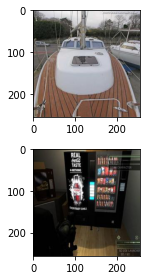

In [56]:
plotRGBImages(train_rgb_ds, 2)

Plotting the LAB Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LAB Image - 0


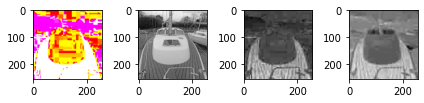

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------
LAB Image - 1


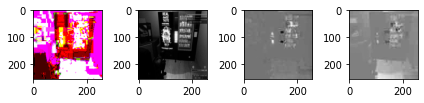

----------------------------------------------------


In [62]:
plotLABImages(train_lab_ds, 2, cmap='gray')

#### Mapping the datasets for testing


In [93]:
# getting the RGB Images dataset from the testing Dataset
test_rgb_ds = test_ds.map(lambda x : tf.py_function(getRGBData, [x], [tf.float32]))

In [64]:
# getting the LAB Images dataset from the collected testing RGB Dataset
test_lab_ds = test_rgb_ds.map(lambda x : tf.py_function(getLABData, [x], [tf.float32]))

In [65]:
# getting the data to test model i.e L(X) & AB(Y) channels from the collected LAB Dataset
testData = test_lab_ds.map(lambda x : tf.py_function(getXYDataset, [x], [tf.float32, tf.float32]))

In [95]:
# testing
_test = test_rgb_ds.shuffle(buffer_size=100,reshuffle_each_iteration=True)

Checking the each Dataset Image shapes

In [98]:
for t, rgb in enumerate(train_rgb_ds.batch(1)):
    print(f'RGB Images {t} Shape :{np.array(rgb).shape}')

Streaming output truncated to the last 5000 lines.
RGB Images 2040 Shape :(1, 1, 256, 256, 3)
RGB Images 2041 Shape :(1, 1, 256, 256, 3)
RGB Images 2042 Shape :(1, 1, 256, 256, 3)
RGB Images 2043 Shape :(1, 1, 256, 256, 3)
RGB Images 2044 Shape :(1, 1, 256, 256, 3)
RGB Images 2045 Shape :(1, 1, 256, 256, 3)
RGB Images 2046 Shape :(1, 1, 256, 256, 3)
RGB Images 2047 Shape :(1, 1, 256, 256, 3)
RGB Images 2048 Shape :(1, 1, 256, 256, 3)
RGB Images 2049 Shape :(1, 1, 256, 256, 3)
RGB Images 2050 Shape :(1, 1, 256, 256, 3)
RGB Images 2051 Shape :(1, 1, 256, 256, 3)
RGB Images 2052 Shape :(1, 1, 256, 256, 3)
RGB Images 2053 Shape :(1, 1, 256, 256, 3)
RGB Images 2054 Shape :(1, 1, 256, 256, 3)
RGB Images 2055 Shape :(1, 1, 256, 256, 3)
RGB Images 2056 Shape :(1, 1, 256, 256, 3)
RGB Images 2057 Shape :(1, 1, 256, 256, 3)
RGB Images 2058 Shape :(1, 1, 256, 256, 3)
RGB Images 2059 Shape :(1, 1, 256, 256, 3)
RGB Images 2060 Shape :(1, 1, 256, 256, 3)
RGB Images 2061 Shape :(1, 1, 256, 256, 3)
RGB

In [ ]:
for lab in test_lab_ds.batch(32):
    print('LAB Images Shape :', np.array(lab).shape)

In [79]:
for _l, _ab in testData.batch(32):
    print('L Shape : ', np.array(_l).shape)
    print('AB Shape : ', np.array(_ab).shape)

L Shape :  (32, 256, 256, 1)
AB Shape :  (32, 256, 256, 2)
L Shape :  (32, 256, 256, 1)
AB Shape :  (32, 256, 256, 2)
L Shape :  (32, 256, 256, 1)
AB Shape :  (32, 256, 256, 2)


InvalidArgumentError: ignored

Visualization of Testing Dataset

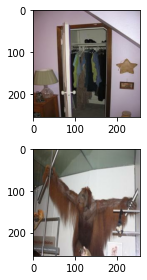

In [ ]:
plotRGBImages(test_rgb_ds, 2)

Plotting the LAB Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LAB Image - 0


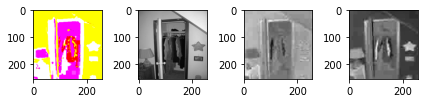

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------
LAB Image - 1


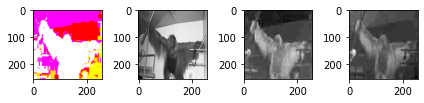

----------------------------------------------------


In [ ]:
plotLABImages(test_lab_ds, 2, cmap='gray')

#### Mapping the datasets for validation


In [ ]:
# getting the RGB Images dataset from the Original Validation Dataset
val_rgb_ds = val_ds.map(getRGBData)

In [ ]:
# getting the LAB Images dataset from the collected Validation RGB Dataset
val_lab_ds = val_rgb_ds.map(getLABData)

In [ ]:
# getting the data to validate model i.e L(X) & AB(Y) channels from the collected LAB Dataset
valData = val_lab_ds.map(getXYDataset)

Checking the each Dataset Image shapes

In [ ]:
for rgb in val_rgb_ds.take(1):
    print('RGB Images Shape :', rgb.numpy().shape)

RGB Images Shape : (256, 256, 3)


In [ ]:
for lab in val_lab_ds.take(2):
    print('LAB Images Shape :', lab.numpy().shape)

LAB Images Shape : (256, 256, 3)
LAB Images Shape : (256, 256, 3)


In [ ]:
for _l, _ab in valData.batch(32).take(1):
    print('L Shape : ',_l.numpy().shape)
    print('AB Shape : ',_ab.numpy().shape)

L Shape :  (32, 256, 256, 1)
AB Shape :  (32, 256, 256, 2)


Visualization of Testing Dataset

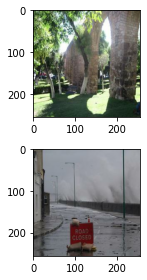

In [ ]:
plotRGBImages(val_rgb_ds, 2)

Plotting the LAB Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LAB Image - 0


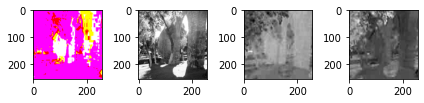

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------
LAB Image - 1


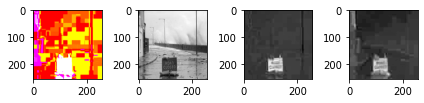

----------------------------------------------------


In [ ]:
plotLABImages(val_lab_ds, 2, cmap='gray')

#### Setting up the configuration for train-test-val dataset

In [ ]:
# setting the batch size of the input dataset
batchSize = 32                              # since 8800 / 32 = 275

In [ ]:
def config_ds(ds, batch_size):

    # setting up the cache 
    ds = ds.cache()
    # setting up the batch_size
    ds = ds.batch(batch_size)
    # setting up the prefectch freq
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [ ]:
trainData = config_ds(trainData, batchSize)
testData = config_ds(testData, batchSize)
valData = config_ds(valData, batchSize)

In [ ]:
valData

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 2)), types: (tf.float32, tf.float32)>

### Creating the Autoencoder Model

#### Model Variables

In [ ]:
# model variables
input_shape = (256,256,1)           # input shape of the nn
num_epochs = 10                     # no of epochs to train  the model

# instantiate the optimizers function
optimizer_fn = keras.optimizers.adam_v2.Adam(learning_rate=1e-3)

# instantiate the loss function
loss_fn = keras.losses.MeanSquaredError()   

# metrices for train and val accuracy 

train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

# var for recording the losses and the accuracy while training and validating
train_loss = []
val_loss = []
train_acc = []
val_acc = []

#  defining the model save / load path 
model_path = ''

# defining the history of model save / load path
history_path = ''

#### AutoEncoder NN Architecture

In [ ]:
def autoEncoder(inputShape = input_shape):

    # input layer
    input_L = Input(shape = inputShape)

    # encoder

    # l1 
    l1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',strides=2)(input_L)

    # l2
    l2 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(l1)
    
    # l3
    l3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', strides=2)(l2)

    # l4
    l4 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(l3)

    # l5
    l5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', strides=2)(l4)

    # l6
    l6 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(l5)

    # l7
    l7 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(l6)

    # l8
    l8 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(l7)


    # decoder

    # l9
    l9 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(l8)
    l9_up = UpSampling2D((2,2))(l9)

    # l10
    l10 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l9_up)
    l10_up = UpSampling2D((2,2))(l10)

    # l11
    l11 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l10_up)

    # l12
    l12 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l11)

    # l13
    l13 = Conv2D(filters=2, kernel_size=(3,3), activation='tanh', padding='same')(l12)
    l13_up = UpSampling2D((2,2))(l13)

    return Model(inputs=input_L, outputs=l13_up)

In [ ]:
model = autoEncoder()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 512)       1180

### Training the Model

In [ ]:
# for epoch in range(num_epochs):
#     print(f'\n Starting the epoch : {epoch}')
#     start_time = time.time()

#     # Iterating over the batches in the training dataset
#     for step, (x_train_batch, y_train_batch) in trainData.take(10).enumerate():
#         with tf.GradientTape() as tape:
#             print(x_train_batch.numpy().shape)
#             ypred = model(x_train_batch.numpy(), training=True)
#             print(ypred.shape)
#             print(y_train_batch.numpy().shape)
#             lossValue = loss_fn(y_train_batch.numpy(), ypred)

#         # recording the training loss
#         train_loss.append(lossValue)

#         grads = tape.gradient(lossValue, model.trainable_weights)
#         optimizer_fn.apply_gradients(zip(grads, model.trainable_weights))

#         # Update training metric.
#         train_acc_metric.update_state(y_train_batch.numpy(), ypred)

#         # Log every 275 batches.
#         if step % 275 == 0:
#             print(f'Training loss (for one batch) at step {step} : {lossValue}')
#             print(f'Seen so far: {(step + 1) * batchSize} samples')

#     # Display metrics at the end of each epoch.
#     train_acc_result = train_acc_metric.result()

#     # recording the training accuracy
#     train_acc.append(train_acc_result)

#     print("Training acc over epoch: %.4f" % (float(train_acc_result),))

#     # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

#     # Run a validation loop at the end of each epoch.
#     for x_val_batch, y_val_batch in valData:
#         valPred = model(x_val_batch.numpy(), training=False)
#         valLossValue = loss_fn(y_val_batch.numpy(), valPred)

#         # recording the validation loss
#         val_loss.append(valLossValue)

#         # Update val metrics
#         val_acc_metric.update_state(y_val_batch.numpy(), valPred)

#     val_acc_result = val_acc_metric.result()

#     # recording the val_acc_result
#     val_acc.append(val_acc_result)

#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc_result),))

#     print("Time taken: %.2fs" % (time.time() - start_time))



In [ ]:
testData

<MapDataset shapes: ((256, 256, 1), (256, 256, 2)), types: (tf.float32, tf.float32)>

In [ ]:
for epoch in range(5):
    print(f'\n Starting the epoch : {epoch}')
    # start_time = time.time()

    # Iterating over the batches in the training dataset
    try:
        step = 0
        for (x_train_batch, y_train_batch) in testData.batch(1):
            print(f'Steps : {step} ======= Xtrain Batch : {x_train_batch.shape} ======= Ytrain Batch : {y_train_batch.shape}')
            step += 1
    except Exception as e:
        print(e)

    print('-------------------------------------------------------------')
    # print("Time taken: %.2fs" % (time.time() - start_time))




 Starting the epoch : 0
Steps : 0 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 1 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 2 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 3 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 4 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 5 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 6 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 7 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 8 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 9 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (1, 256, 256, 2)
Steps : 10 ======= Xtrain Batch : (1, 256, 256, 1) ======= Ytrain Batch : (

In [ ]:
train_rgb_ds

<MapDataset shapes: (None, None, None), types: tf.float32>

In [ ]:
for epoch in range(2):
    print(f'\n Starting the epoch : {epoch}')
    # start_time = time.time()

    # Iterating over the batches in the training dataset
    try:
        step = 0
        for (x_train_batch, y_train_batch) in trainData.batch(88):
            print(f'Steps : {step} ======= Xtrain Batch : {x_train_batch.shape} ======= Ytrain Batch : {y_train_batch.shape}')
            step += 1
    except Exception as e:
        print(e)

    print('-------------------------------------------------------------')
    # print("Time taken: %.2fs" % (time.time() - start_time))




 Starting the epoch : 0
Steps : 0 ======= Xtrain Batch : (88, 256, 256, 1) ======= Ytrain Batch : (88, 256, 256, 2)
Steps : 1 ======= Xtrain Batch : (88, 256, 256, 1) ======= Ytrain Batch : (88, 256, 256, 2)
Matrix size-incompatible: In[0]: [65536,1], In[1]: [3,3]
	 [[{{node Tensordot/ArithmeticOptimizer/FoldTransposeIntoMatMul_MatMul}}]] [Op:IteratorGetNext]
-------------------------------------------------------------

 Starting the epoch : 1
Steps : 0 ======= Xtrain Batch : (88, 256, 256, 1) ======= Ytrain Batch : (88, 256, 256, 2)
Steps : 1 ======= Xtrain Batch : (88, 256, 256, 1) ======= Ytrain Batch : (88, 256, 256, 2)
Matrix size-incompatible: In[0]: [65536,1], In[1]: [3,3]
	 [[{{node Tensordot/ArithmeticOptimizer/FoldTransposeIntoMatMul_MatMul}}]] [Op:IteratorGetNext]
-------------------------------------------------------------


In [ ]:
model.compile(optimizer='adam', loss='mse',metrics='accuracy')

In [ ]:
model.fit_generator(trainData, epochs=num_epochs, validation_data=valData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
  7/220 [..............................] - ETA: 1:35 - loss: 211.1441 - accuracy: 0.6758

InvalidArgumentError: ignored

### TimePass Code

In [ ]:
x = []
for lab in train_lab_ds.batch(32).take(1):
    print(lab)

In [ ]:
# plot trainData images
x = []
y = []
for _l, _ab in trainData.batch(32).take(1):
    x.append(_l.numpy())
    y.append(_ab.numpy())

In [ ]:
x = np.asarray(x)
y = np.asarray(y)

In [ ]:
x.shape

(1, 32, 256, 256, 1)

In [ ]:
y.shape

(1, 32, 256, 256, 2)

In [ ]:
results = []

for X, Y in zip(x[0], y[0]):
    zeroes = np.zeros(shape = (256,256,3))

    zeroes[:,:,0] = np.reshape(X, (256,256))
    zeroes[:,:,1:] = Y
    zeroes = lab2rgb(zeroes)
    results.append(zeroes)


In [ ]:
results = np.asarray(results)

In [ ]:
results.shape

(32, 256, 256, 3)

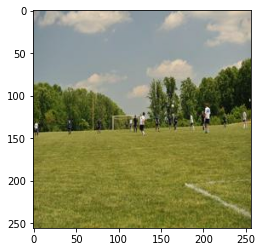

In [ ]:
plt.imshow(results[5])